# 🧠 Fake News Detection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import shap
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sutha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load your dataset
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

fake_df['label'] = 0
true_df['label'] = 1
df = pd.concat([fake_df, true_df], ignore_index=True)[["title", "text", "label"]]

In [4]:
# Preprocess text
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    words = text.split()
    stop_words = stopwords.words("english")
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

df['text'] = df['title'] + ' ' + df['text']
df['text'] = df['text'].apply(clean_text)

In [5]:
# TF-IDF and Split
vectorizer = TfidfVectorizer(max_df=0.7)
X = vectorizer.fit_transform(df['text'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Logistic Regression
[[4678   55]
 [  50 4197]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4733
           1       0.99      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Accuracy: 0.9883


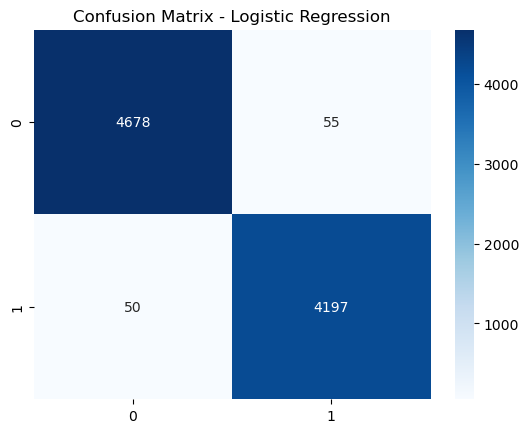


Naive Bayes
[[4474  259]
 [ 231 4016]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4733
           1       0.94      0.95      0.94      4247

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980

Accuracy: 0.9454


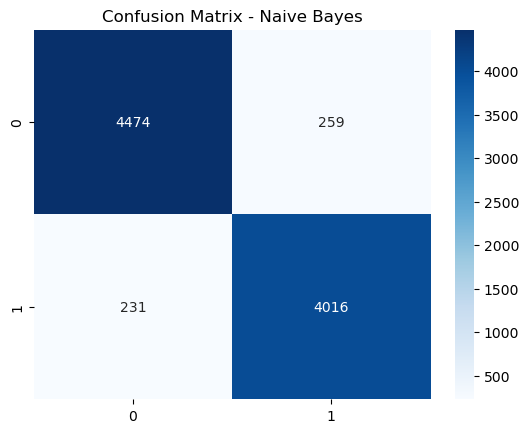


Random Forest
[[4698   35]
 [  34 4213]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4733
           1       0.99      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Accuracy: 0.9923


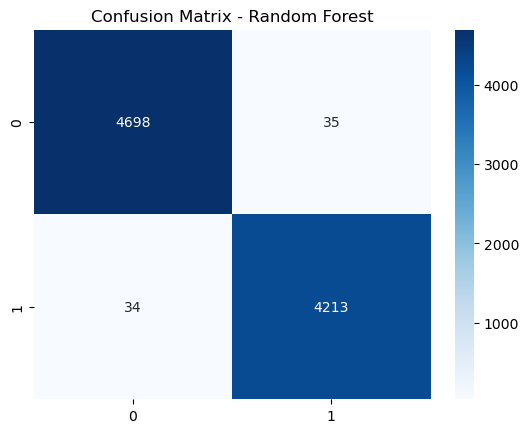

In [6]:
# Model training and evaluation with visualization
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    print(f"\n{name}\n{'='*len(name)}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))
    print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

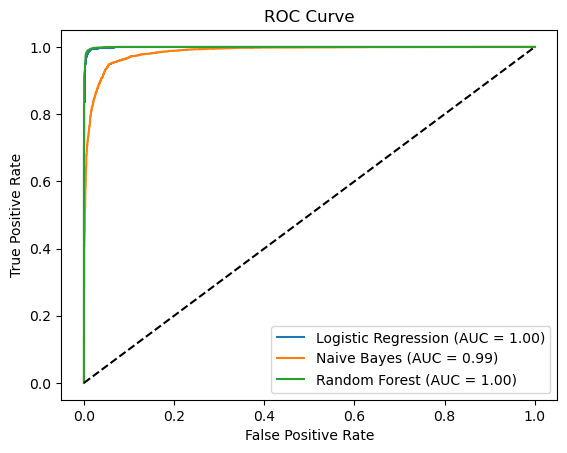

In [7]:
# ROC Curve for all models
for name, model in models.items():
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

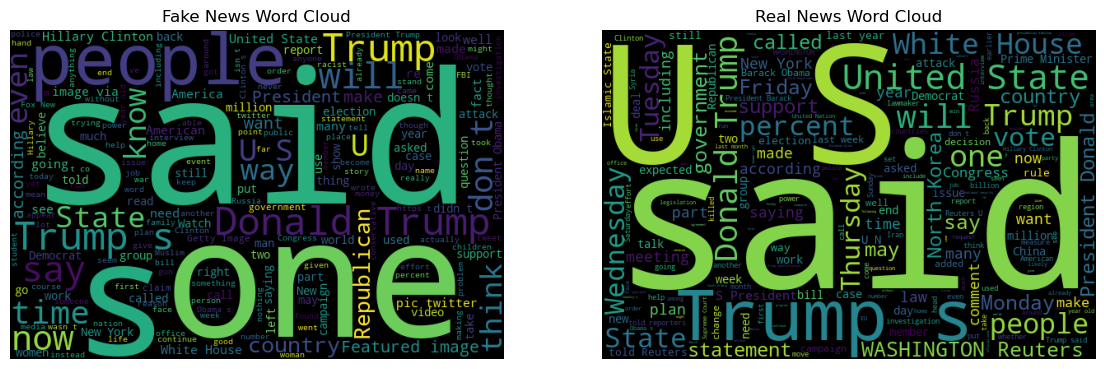

In [8]:
# Word Clouds
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400).generate(" ".join(fake_df["text"])))
plt.title("Fake News Word Cloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400).generate(" ".join(true_df["text"])))
plt.title("Real News Word Cloud")
plt.axis("off")
plt.show()

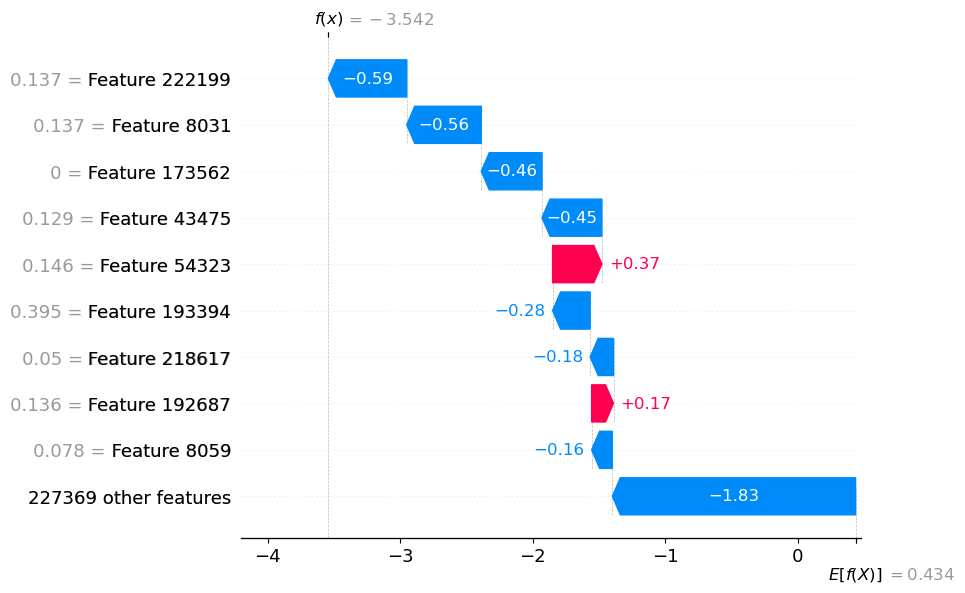

In [9]:
# SHAP Explainability for best model
best_model = LogisticRegression()
best_model.fit(X_train, y_train)

explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test[:100])
shap.plots.waterfall(shap_values[0])

In [10]:
# Save the best model and vectorizer for deployment
import pickle

best_model = LogisticRegression()
best_model.fit(X_train, y_train)

LogisticRegression()

In [11]:
# Save model and vectorizer
pickle.dump(best_model, open("model.pkl", "wb"))

In [12]:
pickle.dump(vectorizer, open("vectorizer.pkl", "wb"))

In [ ]:
# Test user input
sample_text = input("Enter a news article to check if it's FAKE or TRUE:\n")
cleaned_sample = clean_text(sample_text)
vectorized_sample = vectorizer.transform([cleaned_sample])
prediction = best_model.predict(vectorized_sample)[0]

print("\nPrediction Result:")
print("TRUE ✅" if prediction == 1 else "FAKE ❌")